<h3>Design Patterns with First-Class Functions</h3>

In the context of languages with first-class functions, Peter Norvig suggests rethinking the Strategy, Command, Template Method, and Visitor patterns. The idea is: you can replace instances of some participant class in these patterns with simple functions, reducing a lot of boilerplate code. We will refactor Strategy using function objects, and discuss a similar approach to simplifying the Command pattern.

The Strategy pattern is summarized like this in <i>Design Patterns</i>:

Deifne a family of algorithms, encapsulate each one, and make them interchangeable. Strategy lets the algorithm vary independently from clients that use it.

A clear example of Strategy applied in the ecommerce domain is computing discounts to orders according to the attributes of the customer or inspection of the ordered items.

Consider an online store with these discount rules:

* Customers with 1,000 or more fidelity points get a global 5% discount per order.
* A 10% discount is applied to each line item with 20 or more units in the same order.
* Orders with at least 10 distinct items get a 7% global discount.



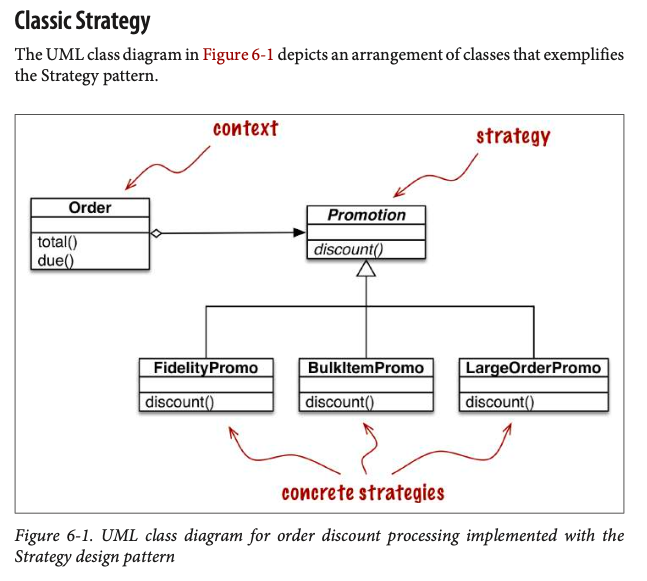



Participants of the UML diagram:

<i>Context</i>

Provides a service by delegating some computation to interchangeable components that implement alternative algorithms. In the ecommerce example, the context is an `Order`, which is configured to apply a promotional discount according to one of several algorithms.

<i>Strategy</i>

The interface common to the components that implement the different algorithms. In our example, this role is played by an abstract class called `Promotion`.

<i>Concrete Strategy</i>

One of the concrete subcasses of `Strategy`. `FidelityPromo, BulkPromo, LargeOrderPromo` are the three concrete strategies implemented.

Code below.

In [8]:
from abc import ABC, abstractmethod
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')

class LineItem:
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    
    
class Order: # the Context
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())
    

class Promotion(ABC): # the Strategy: an abstract base class
    """Make this an ABC to use @abstractmethod and make the pattern more explicit"""
    
    @abstractmethod
    def discount(self, order):
        """Return discount as a positive dollar amount"""
        
        
class FidelityPromo(Promotion): # first Concrete Strategy
    """5% discount for customers with 1,000 or more fidelity points"""
    
    def discount(self, order):
        return order.total() * .05 if order.customer.fidelity >= 1000 else 0
        

class BulkItemPromo(Promotion): # second Concrete Strategy
    """10% discount for each LineItem with 20 or more units"""
    
    def discount(self, order):
        discount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * .1
        return discount
    

class LargeOrderPromo(Promotion): # third Concrete Strategy
    """7% discount for orders with 10 or more distinct items"""
    
    def discount(self, order):
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * .07
        return 0

In [9]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = [LineItem('banana', 4, .5),
        LineItem('apple', 10, 1.5),
        LineItem('watermelon', 5, 5.0)
       ]
Order(joe, cart, FidelityPromo())

<Order total: 42.00 due: 42.00>

In [10]:
Order(ann, cart, FidelityPromo())

<Order total: 42.00 due: 39.90>

In [11]:
banana_cart = [LineItem('banana', 30, .5),
               LineItem('apple', 10, 1.5)
              ]
Order(joe, banana_cart, BulkItemPromo())

<Order total: 30.00 due: 28.50>

In [12]:
long_order = [LineItem(str(item_code), 1, 1.0)
              for item_code in range(10)
             ]
Order(joe, long_order, LargeOrderPromo())

<Order total: 10.00 due: 9.30>

In [13]:
Order(joe, cart, LargeOrderPromo())

<Order total: 42.00 due: 42.00>

<h3>Function-Oriented Strategy</h3>

This works, but the same functionality can be implemented with less code in Python by using functions as objects.

Each concrete strategy is a class with a single method, `discount`. The strategy instances have no state (no instance attributes). They look a lot like plain functions. Below is a refactoring of this, replacing strategies with simple functions and removing the `Promo` abstract class.

In [18]:
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')

class LineItem:
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    

class Order: # the Context
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion(self)  # to compute discount, just call self.promotion() function
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())
    
# No more abstract class, just functions for the promotions. Each strategy is a function.

def fidelity_promo(order):
    """5% discount for customers with 1,000 or more fidelity points"""
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0


def bulk_item_promo(order):
    """10% discount for each LineItem with 20 or more units"""
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount


def large_order_promo(order):
    """7% discount for orders with 10 or more distinct items"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [19]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = [LineItem('banana', 4, .5),
        LineItem('apple', 10, 1.5),
        LineItem('watermelon', 5, 5.0)
       ]
Order(joe, cart, fidelity_promo)

<Order total: 42.00 due: 42.00>

In [20]:
Order(ann, cart, fidelity_promo)

<Order total: 42.00 due: 39.90>

In [21]:
banana_cart = [LineItem('banana', 30, .5),
               LineItem('apple', 10, 1.5)
              ]
Order(joe, banana_cart, bulk_item_promo)

<Order total: 30.00 due: 28.50>

In [22]:
long_order = [LineItem(str(item_code), 1, 1.0)
              for item_code in range(10)
             ]
Order(joe, long_order, large_order_promo)

<Order total: 10.00 due: 9.30>

In [23]:
Order(joe, cart, large_order_promo)

<Order total: 42.00 due: 42.00>

<h3>Choosing the Best Strategy: Simple Approach</h3>

Suppose we now want to create a "meta-strategy" that selects the best available discount for a given `Order`. 

In [24]:
# Once you are used to the idea of functions being first-class objects, it naturally follows that
# building data structures holding functions often makes sense

promos = [fidelity_promo, bulk_item_promo, large_order_promo]

def best_promo(order):
    """Select best discount available"""
    
    return max(promo(order) for promo in promos)

In [25]:
Order(joe, long_order, best_promo) # large_order_promo selected 

<Order total: 10.00 due: 9.30>

In [26]:
Order(joe, banana_cart, best_promo) # bulk_item_promo selected

<Order total: 30.00 due: 28.50>

In [29]:
Order(ann, cart, best_promo) # fidelity_promo selected

<Order total: 42.00 due: 39.90>

This strategy is implemented above. While simple and easy to read, in order to add a new promotion strategy, we need to code the function and remember to add it to the `promos` list, or else the new promotion will not be considered by best_promotion, and only when explicitly passed as an argument to `Order`.

<h3>Finding Strategies in a Module</h3>

Modules in Python are also first-class objects, and the standard library provides several functions to handle them. The built-in `globals` is described as follows in the Python docs:

`globals()`

    Return a dictionary representing the current global symbol table. This is always the dictionary of the current module (inside a function or method, this is the module where it is defined, not the module from which it is called).

In [30]:
# Somewhat hackish way of using globals to help best_promo find other *_promo functions

promos = [globals()[name] for name in globals()
          if name.endswith('_promo')
          and name != 'best_promo']
promos

[<function __main__.fidelity_promo(order)>,
 <function __main__.bulk_item_promo(order)>,
 <function __main__.large_order_promo(order)>]

In [31]:
def best_promo(order):
    """Select best discount available"""
    
    return max(promo(order) for promo in promos)

Another way of collecting the available promotions would be to create a module and put all the strategy functions there, except for `best_promo`. This is shown below with the list of strategy functions built by introspection of a separate module called `promotions`. 

**Note that this code assumes that the `promotions` module contains only functions that calculate discounts given orders. If someone were to create a function with a different signature in the `promotions` module, then `best_promo` would break while trying to apply it to an order. We could apply more stringent tests to filter the functions, by inspecting their arguments for instance.**

In [35]:
import inspect
# import promotions

try:
    promos = [func for name, func in 
                 inspect.getmembers(promotions, inspect.isfunction)
    ]
except NameError:
    print('Promotions isn\'t an actual module here')
    
def best_promo(order):
    """Select the best discount available"""
    
    return max(promo(order) for order in promos)

Promotions isn't an actual module here


<h3>Command Design Pattern</h3>

Command is another design pattern that is sometimes implemented via single-method classes when plain functions would do. It is another design pattern that can be simplified by the use of functions passed as arguments.